# Twitter Sentiment Analysis Bot

* Found at twitter handle [@5000Awesomeo](https://twitter.com/5000Awesomeo)

* Not presently in live production, but will be shortly

In [1]:
# Outlining

# Pre-planning
    # Need to get a bot Twitter account with its own unique API keys, separate from personal account

# Your bot should scan your account every **five minutes** for mentions.
# Your script should prevent abuse by analyzing **only** Twitter accounts that have not previously been analyzed.

    # Create master function which uses time.sleep(300) to search for mentions.
    # Use api.mentions_timeline() to capture mentions
    # Have dedupe step for only new mentions
    # Have dedupe step for only new users
    # ID the user

# Your bot should pull 500 most recent tweets to analyze for each incoming request.
    
    # Break down the incoming request to identify the requested user and requesting user.
    # use api.user_timeline() to do sentiment analysis
    # Plot using MatPlotLib
    # Save to PNG file

# Tweet
    # Tweet the PNG file with a message
    # Compose text with following guideline: 'Tweet Analysis: @analyzed_User (Thanks @requesting_user)'

In [2]:
from pprint import pprint

# Dependencies

import datetime
import time
import requests

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

# Import tweepy
import tweepy
from twitter_config import (consumer_key,
                            consumer_secret,
                            access_token,
                            access_token_secret)

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [3]:
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [4]:
old_analyzed_users = []
old_analyzed_tweets = []

# This function checks for duplicate tweets and analysis requests
# It adds to lists of previously analyzed users (old_analyzed_users) and previously analyzed tweets (old_analyzed_tweets)
# Its output is user_pairs, a list of dicts pairing Analysis Requested and User Requesting

def check_mentions():
    
    #Locally generated mentions data to be passed onto other functions
    global new_mentions
    
    new_mentions = []

    mentions = api.mentions_timeline()
        
    for mention in mentions:
    
        # if tweet already analyzed, pass
        if mention['id'] in old_analyzed_tweets:
            pass

        else:
            #add to old_analyzed_tweets to avoid subsequent duplication
            old_analyzed_tweets.append(mention['id'])
            
            #returns a list of all users mentioned in the tweet
            user_mentions = mention['entities']['user_mentions']
        
            for user in user_mentions:
            
                # If mentioned user is the bot itself, ignore
                if user['screen_name'] == '5000Awesomeo':
                    pass
                
                else:
                    # If mentioned user has already analyzed, pass
                    if user['screen_name'] in old_analyzed_users:
                        pass
                    # If mentioned user is new, add to previously analyzed users
                    # Also add a dict requested analysis, requesting user, and status id of request
                    else:
                        old_analyzed_users.append(user['screen_name'])
                        #Used an insert() below instead of append() so oldest newly detected tweet goes first
                        new_mentions.insert(0, {'Analysis requested': user['screen_name'],
                                                  'User requesting': mention['user']['screen_name'],
                                                  'Request Status ID' : mention['id']
                                                 })

In [5]:
# This function pulls 500 tweets from target_user and does the sentiment analysis

def sentiment_analysis(target_user):
    
    #global sentiment_list built to pass to other functions
    global sentiment_list
    
    target_user = target_user
    
    sentiment_list = []
    
    #This acts as a counter for the '# of tweets ago'. starts at 0, ends at -500
    tweets_ago = 1
    
    for page in range(5):

        public_tweets = api.user_timeline(target_user, page=page, count=100)
    
        for tweet in public_tweets:
        
            text = tweet['text']
        
            score = analyzer.polarity_scores(text)
            
            tweets_ago -=1
        
            sentiment_list.append({'Compound Score': score['compound'],
                                'Tweets Ago': tweets_ago})

In [6]:
#takes the sentiment scores from sentiment_analysis and generates the sentiment plot

def generate_plot(target_user):

    sentiment_df = pd.DataFrame(sentiment_list)

    # figure out the date to put on plots
    date = datetime.date.today().strftime("%B %d, %Y")  
    
    plot = sentiment_df.plot('Tweets Ago', 
                             'Compound Score',
                             marker='o',
                             markerfacecolor='white',
                             markeredgecolor='blue',
                             linewidth=1,
                             figsize=(12,9),
                             kind='line',
                             fontsize=15,
                             antialiased = True)
    
    plot.set_title(f'''Sentiment Analysis of @{target_user}\n(Generated {date})''', fontsize=20)
    
    plot.set_xlabel('Tweets Ago', fontsize=15)
    plot.set_ylabel('Tweet Polarity', fontsize=15)
    
    plot.set_ylim([-1, 1])
    
    plot.grid(True)
        
    plot.legend().set_visible(False)
    
    fig = plot.get_figure()
    
    fig.savefig('output.png')

In [7]:
#Makes the API call, calling sentiment_analysis() and generate_plot()

def generate_tweets():

    for mention in new_mentions:
    
        requested_subject = mention['Analysis requested']
        
        user_requesting = mention['User requesting']
        
#        Tweepy has a field 'status id of tweet replying to' field, would like to figure this out to link to original tweet request
        request_status_id = str(mention['Request Status ID'])
        
        sentiment_analysis(requested_subject)
        
        generate_plot(requested_subject)
                
        tweet_text = f'''Sentiment analysis of @{requested_subject}'s previous 500 tweet (requested by @{user_requesting})'''
        
        api.update_with_media('output.png', tweet_text, request_status_id)

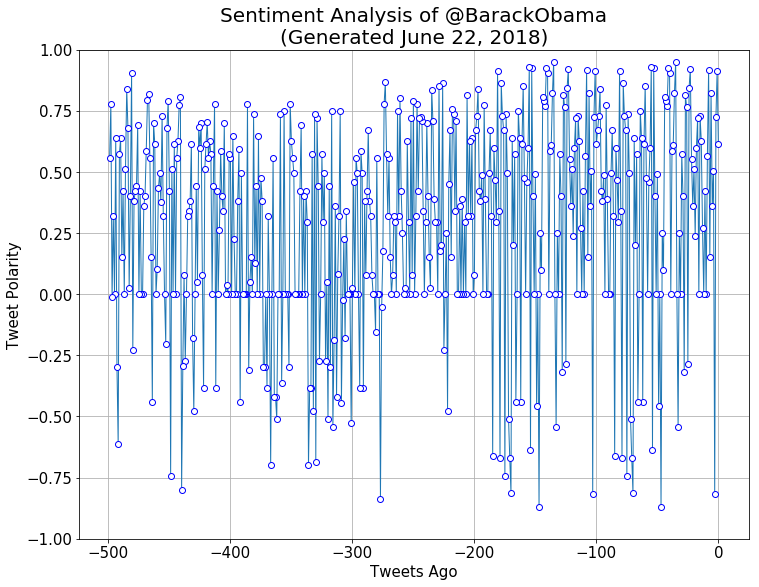

In [8]:
#Testing functions

sentiment_analysis('BarackObama')
generate_plot('BarackObama')

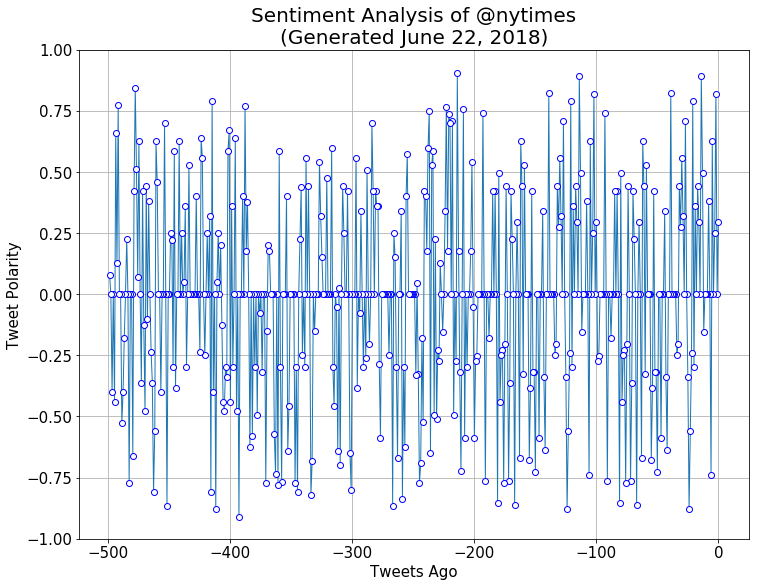

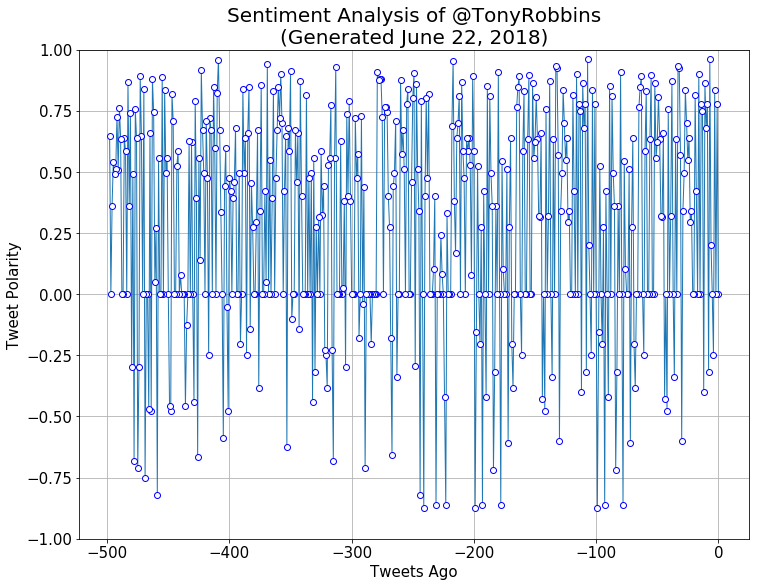

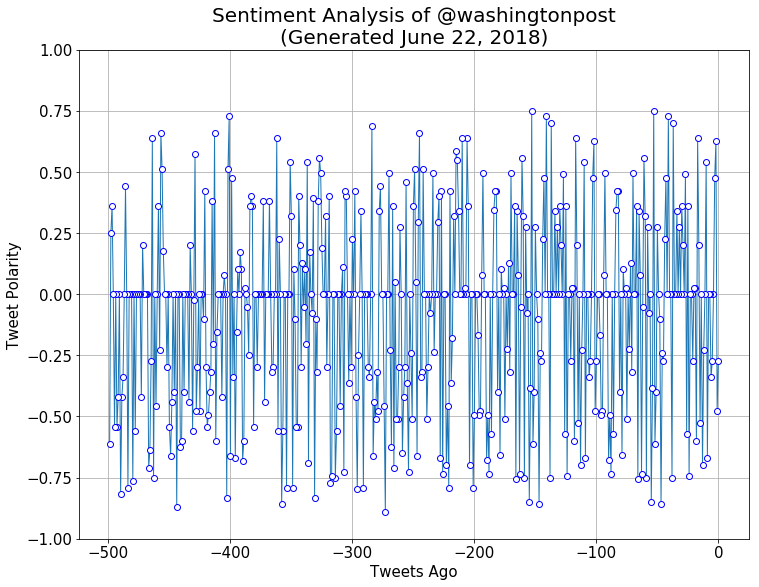

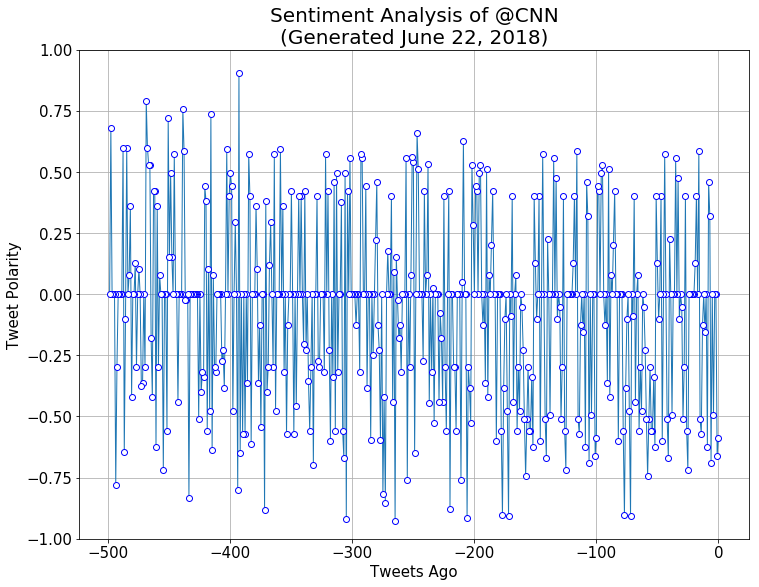

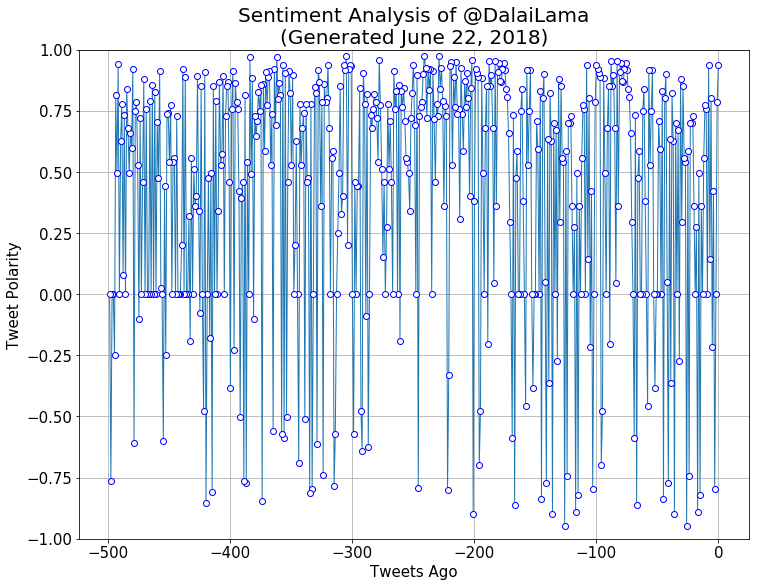

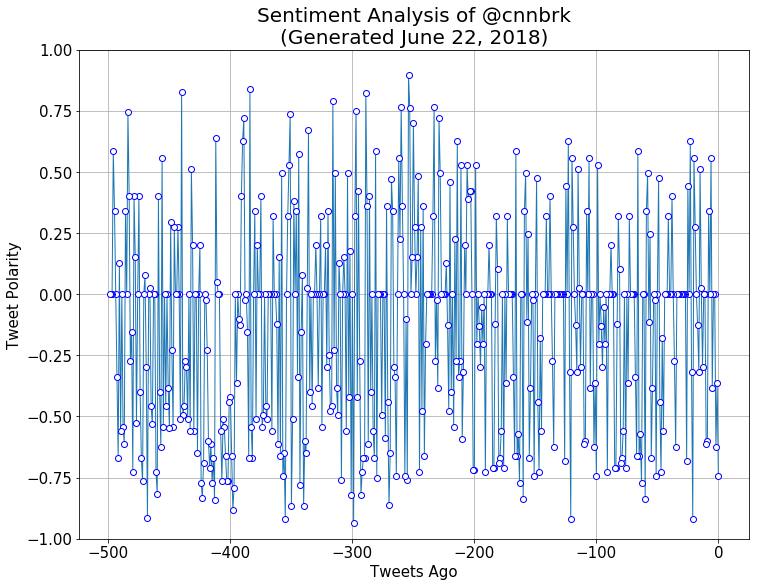

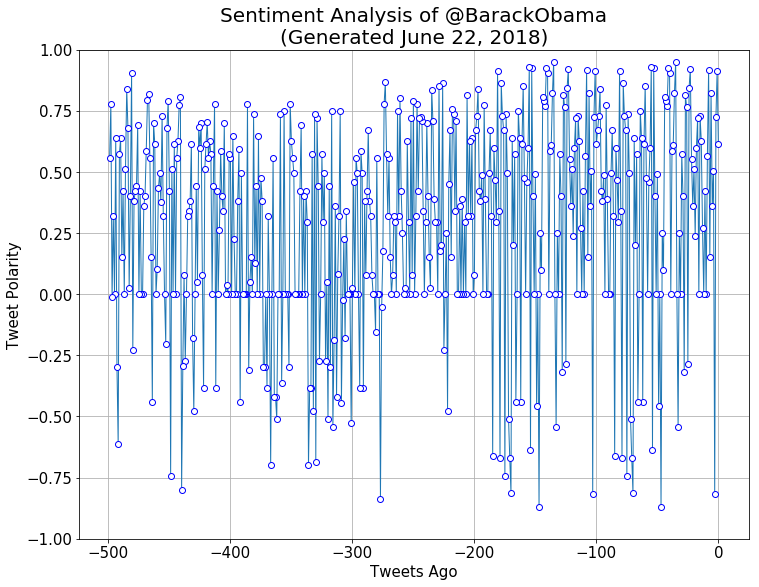

In [ ]:
check_mentions()
generate_tweets()

In [ ]:
# Global code for the actual program to run indefinitely, running the loop every 5 minutes

while True:
    check_mentions()
    generate_tweets()
    time.sleep(300)